In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/riiid-test-answer-prediction/example_sample_submission.csv
/kaggle/input/riiid-test-answer-prediction/train.csv
/kaggle/input/riiid-test-answer-prediction/example_test.csv
/kaggle/input/riiid-test-answer-prediction/questions.csv
/kaggle/input/riiid-test-answer-prediction/lectures.csv
/kaggle/input/riiid-test-answer-prediction/riiideducation/__init__.py
/kaggle/input/riiid-test-answer-prediction/riiideducation/competition.cpython-37m-x86_64-linux-gnu.so


In [5]:
import pandas as pd
import numpy as np
import lightgbm as lgb
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
import gc

In [2]:
import riiideducation
env = riiideducation.make_env()

ModuleNotFoundError: No module named 'riiideducation'

In [6]:
# dir_path = '/kaggle/input/riiid-test-answer-prediction/'
dir_path = '/home/zuoyuhui/datasets/riid准确回答/'
file_train = 'train.csv'
file_questions = 'questions.csv'
file_lectures = 'lectures.csv'

In [7]:
nrows = 100 * 10000
# nrows = None

In [8]:
train = pd.read_csv(
                    dir_path + file_train, 
                    nrows=nrows, 
                    usecols=['row_id', 'timestamp', 'user_id', 'content_id', 
                             'content_type_id', 'task_container_id', 'answered_correctly',
                            'prior_question_elapsed_time','prior_question_had_explanation'],
                    dtype={
                            'row_id': 'int64',
                            'timestamp': 'int64',
                            'user_id': 'int32',
                            'content_id': 'int16',
                            'content_type_id': 'int8',
                            'task_container_id': 'int8',
                            'answered_correctly': 'int8',
                            'prior_question_elapsed_time': 'float32',
                            'prior_question_had_explanation': 'str'
                        }
                   )

In [9]:
lectures = pd.read_csv(
                       dir_path + file_lectures, 
                       usecols=['lecture_id','tag','part','type_of'], 
                       nrows=nrows,
                       dtype={
                           'lecture_id': 'int16',
                           'tag': 'int16',
                           'part': 'int8',
                           'type_of': 'str'
                       }
                    )

In [10]:
questions = pd.read_csv(
                        dir_path + file_questions, 
                        nrows=nrows,
                        usecols=['question_id','bundle_id','part','tags'], 
                        dtype={
                           'question_id': 'int16',
                           'bundle_id': 'int16',
                           'part': 'int8',
                           'tags': 'str'
                       }
                    )

In [11]:
# 数据处理
train['prior_question_had_explanation'] = train['prior_question_had_explanation'].map({'True':1,'False':0}).fillna(-1).astype(np.int8)
lectures['type_of'] = lectures['type_of'].map({'concept':0, 'intention':1, 'solving question':2, 'starter':3}).fillna(-1).astype(np.int8)
questions['tags'] = questions['tags'].fillna('1')
questions['tags'] = questions['tags'].map(lambda x:len(str(x).split(' ')))

In [12]:
# 压缩内存
max_num = 1000
train = train.groupby(['user_id']).tail(max_num)

In [13]:
# 切分数据
train_lectures = train[train['content_type_id']==1]
train_questions = train[train['content_type_id']==0]
del train
gc.collect()

8

In [14]:
# 关联数据
train_lectures_info = pd.merge(
        left=train_lectures,
        right=lectures,
        how='left',
        left_on='content_id',
        right_on='lecture_id'
        )

train_questions_info = pd.merge(
        left=train_questions,
        right=questions,
        how='left',
        left_on='content_id',
        right_on='question_id'
        )

In [15]:
del train_lectures
del train_questions
gc.collect()

22

In [16]:
train_questions_info.head()

,row_id,timestamp,user_id,content_id,content_type_id,task_container_id,answered_correctly,prior_question_elapsed_time,prior_question_had_explanation,question_id,bundle_id,part,tags
0,0,0,115,5692,0,1,1,NaN,-1,5692,5692,5,1
1,1,56943,115,5716,0,2,1,37000.0,0,5716,5716,5,1
2,2,118363,115,128,0,0,1,55000.0,0,128,128,1,3
3,3,131167,115,7860,0,3,1,19000.0,0,7860,7860,1,3
4,4,137965,115,7922,0,4,1,11000.0,0,7922,7922,1,3


In [17]:
train_lectures_info.head()

,row_id,timestamp,user_id,content_id,content_type_id,task_container_id,answered_correctly,prior_question_elapsed_time,prior_question_had_explanation,lecture_id,tag,part,type_of
0,89,653762,2746,6808,1,14,-1,NaN,0,6808,129,2,1
1,117,10183847,5382,16736,1,21,-1,NaN,0,16736,40,1,0
2,212,1424348597,5382,30207,1,104,-1,NaN,0,30207,43,5,0
3,216,1425557777,5382,18545,1,121,-1,NaN,0,18545,58,5,0
4,295,405813029,8623,10540,1,59,-1,NaN,0,10540,99,1,0


In [18]:
gb_columns = ['task_id','part']

In [19]:
# 提取特征函数
# 文献课程类函数
def get_lecture_basic_features__user(train_lectures_info):
    gb_columns = ['user_id']
    gb_suffixes = 'lecture_'+'_'.join(gb_columns)
    
    agg_func = {
        'lecture_id': [np.size], #,np.sum],
        'task_container_id': [lambda x: len(set(x))],
        'tag': [lambda x: len(set(x))],

        # part 展开
        'part': [lambda x: len(set(x))],

        # type_of 展开
        'type_of': [lambda x: len(set(x))],
    }
    columns = [
           gb_suffixes+'_size_lecture_id', 
#            gb_suffixes+'_size_lecture_id_sum', 
           gb_suffixes+'_unique_task_container_id',
           gb_suffixes+'_unique_tag',
           gb_suffixes+'_unique_part',
           gb_suffixes+'_unique_type_of'
          ]  
    train_lectures_info__user_f = train_lectures_info.\
                                groupby(gb_columns).\
                                agg(agg_func).\
                                reset_index()
    
    train_lectures_info__user_f.columns = gb_columns + columns
    return train_lectures_info__user_f

def get_lecture_basic_features__user_tag(train_lectures_info):
    gb_columns = ['user_id','tag']
    gb_suffixes = 'lecture_'+'_'.join(gb_columns)
    agg_func = {
        'lecture_id': [np.size],
        'task_container_id': [lambda x: len(set(x))],
        'tag': [lambda x: len(set(x))],

        # part 展开
        'part': [lambda x: len(set(x))],
    }
    columns = [
               gb_suffixes+'_size_lecture_id', 
               gb_suffixes+'_unique_task_container_id',
               gb_suffixes+'_unique_tag',
               gb_suffixes+'_unique_part'
              ]    
    train_lectures_info__user_tag_f = train_lectures_info.\
                                    groupby(gb_columns).\
                                    agg(agg_func).\
                                    reset_index()
    train_lectures_info__user_tag_f.columns = gb_columns + columns    
    return train_lectures_info__user_tag_f

# 问答类函数
def get_questions_basic_features__user(train_questions_info):
    gb_columns = ['user_id']
    gb_suffixes = 'question_'+'_'.join(gb_columns)
    agg_func = {
        'answered_correctly': [np.mean,np.sum,np.std],

        'question_id': [np.size],
        'task_container_id': [lambda x: len(set(x))],

        'prior_question_elapsed_time': [np.mean,np.max,np.min],

        'prior_question_had_explanation': [lambda x: len(set(x))],

        'bundle_id': [lambda x: len(set(x))],

        # part 展开
        'part': [lambda x: len(set(x))],
        'tags': [lambda x: len(set(x))],
    }
    columns = [
               gb_suffixes+'_answered_correctly_mean',
               gb_suffixes+'_answered_correctly_max',
               gb_suffixes+'_answered_correctly_min',

               gb_suffixes+'_size_question_id', 
               gb_suffixes+'_unique_task_container_id',
               gb_suffixes+'_prior_question_elapsed_time_mean',
               gb_suffixes+'_prior_question_elapsed_time_max',
               gb_suffixes+'_prior_question_elapsed_time_min',

               gb_suffixes+'_unique_prior_question_had_explanation',

               gb_suffixes+'_unique_bundle_id',
               gb_suffixes+'_unique_part',
               gb_suffixes+'_unique_tags',
              ]
    train_questions_info__user_f = train_questions_info.\
                                    groupby(gb_columns).\
                                    agg(agg_func).\
                                    reset_index()
    train_questions_info__user_f.columns = gb_columns + columns    

    return train_questions_info__user_f

def get_questions_basic_features__user_part(train_questions_info):
    gb_columns = ['user_id','part']
    gb_suffixes = 'question_'+'_'.join(gb_columns)
    agg_func = {
        'answered_correctly': [np.mean,np.sum,np.std],

        'question_id': [np.size],
        'task_container_id': [lambda x: len(set(x))],

        'prior_question_elapsed_time': [np.mean,np.max,np.min],

        'prior_question_had_explanation': [lambda x: len(set(x))],

        'bundle_id': [lambda x: len(set(x))],

        # part 展开
        'part': [lambda x: len(set(x))],
        'tags': [lambda x: len(set(x))],
    }
    columns = [
               gb_suffixes+'_answered_correctly_mean',
               gb_suffixes+'_answered_correctly_max',
               gb_suffixes+'_answered_correctly_min',

               gb_suffixes+'_size_question_id', 
               gb_suffixes+'_unique_task_container_id',
               gb_suffixes+'_prior_question_elapsed_time_mean',
               gb_suffixes+'_prior_question_elapsed_time_max',
               gb_suffixes+'_prior_question_elapsed_time_min',

               gb_suffixes+'_unique_prior_question_had_explanation',

               gb_suffixes+'_unique_bundle_id',
               gb_suffixes+'_unique_part',
               gb_suffixes+'_unique_tags',
              ]    
    train_questions_info__user_part_f = train_questions_info.\
                                    groupby(gb_columns).\
                                    agg(agg_func).\
                                    reset_index()
    train_questions_info__user_part_f.columns = gb_columns + columns    

    return train_questions_info__user_part_f

def get_questions_basic_features__content(train_questions_info):
    gb_columns = ['content_id']
    gb_suffixes = 'question_'+'_'.join(gb_columns)
    agg_func = {
        'answered_correctly': [np.mean,np.sum,np.std],

        'user_id': [np.size],

        'prior_question_elapsed_time': [np.mean,np.max,np.min],

        'prior_question_had_explanation': [lambda x: len(set(x))],
    }
    columns = [
               gb_suffixes+'_answered_correctly_mean',
               gb_suffixes+'_answered_correctly_max',
               gb_suffixes+'_answered_correctly_min',

               gb_suffixes+'_size_user_id', 
               gb_suffixes+'_prior_question_elapsed_time_mean',
               gb_suffixes+'_prior_question_elapsed_time_max',
               gb_suffixes+'_prior_question_elapsed_time_min',

               gb_suffixes+'_unique_prior_question_had_explanation',
              ]    
    
    train_questions_info__user_content_f = train_questions_info.\
                                    groupby(gb_columns).\
                                    agg(agg_func).\
                                    reset_index()
    train_questions_info__user_content_f.columns = gb_columns + columns
    
    return train_questions_info__user_content_f

In [20]:
# 预测用户
test_lectures_info__user_f = get_lecture_basic_features__user(train_lectures_info)
# test_lectures_info__user_tag_f = get_lecture_basic_features__user_tag(train_lectures_info)
test_questions_info__user_f = get_questions_basic_features__user(train_questions_info)
# test_questions_info__user_part_f = get_questions_basic_features__user_part(train_questions_info)
test_questions_info__user_content_f = get_questions_basic_features__content(train_questions_info)

In [21]:
# 验证数据
valid_data = pd.DataFrame()

for i in range(6):
    
    # 获取训练标签数据
    last_records = train_questions_info.drop_duplicates('user_id', keep='last')
    
    # 获取训练标签以前的数据
    map__last_records__user_row = dict(zip(last_records['user_id'],last_records['row_id']))
    
    train_questions_info['filter_row'] = train_questions_info['user_id'].map(map__last_records__user_row)
    train_lectures_info['filter_row'] = train_lectures_info['user_id'].map(map__last_records__user_row)

    train_questions_info = train_questions_info[train_questions_info['row_id']<train_questions_info['filter_row']]
    train_lectures_info = train_lectures_info[train_lectures_info['row_id']<train_lectures_info['filter_row']]
    
    # 获取特征
    train_lectures_info__user_f = get_lecture_basic_features__user(train_lectures_info)
    # train_lectures_info__user_tag_f = get_lecture_basic_features__user_tag(train_lectures_info)
    train_questions_info__user_f = get_questions_basic_features__user(train_questions_info)
    # train_questions_info__user_part_f = get_questions_basic_features__user_part(train_questions_info)
    train_questions_info__user_content_f = get_questions_basic_features__content(train_questions_info)

    last_records = last_records.merge(train_lectures_info__user_f,on=['user_id'],how='left')
    last_records = last_records.merge(train_questions_info__user_f,on=['user_id'],how='left')
    last_records = last_records.merge(train_questions_info__user_content_f,on=['content_id'],how='left')
    
    # 特征加入训练集
    valid_data = valid_data.append(last_records)
    print(len(valid_data))

3824
7646
11466
15285
19104
22923


In [22]:
# 训练数据
train_data = pd.DataFrame()

for i in range(10):
    
    # 获取训练标签数据
    last_records = train_questions_info.drop_duplicates('user_id', keep='last')
    
    # 获取训练标签以前的数据
    map__last_records__user_row = dict(zip(last_records['user_id'],last_records['row_id']))
    
    train_questions_info['filter_row'] = train_questions_info['user_id'].map(map__last_records__user_row)
    train_lectures_info['filter_row'] = train_lectures_info['user_id'].map(map__last_records__user_row)

    train_questions_info = train_questions_info[train_questions_info['row_id']<train_questions_info['filter_row']]
    train_lectures_info = train_lectures_info[train_lectures_info['row_id']<train_lectures_info['filter_row']]
    
    # 获取特征
    train_lectures_info__user_f = get_lecture_basic_features__user(train_lectures_info)
    # train_lectures_info__user_tag_f = get_lecture_basic_features__user_tag(train_lectures_info)
    train_questions_info__user_f = get_questions_basic_features__user(train_questions_info)
    # train_questions_info__user_part_f = get_questions_basic_features__user_part(train_questions_info)
    train_questions_info__user_content_f = get_questions_basic_features__content(train_questions_info)

    last_records = last_records.merge(train_lectures_info__user_f,on=['user_id'],how='left')
    last_records = last_records.merge(train_questions_info__user_f,on=['user_id'],how='left')
    last_records = last_records.merge(train_questions_info__user_content_f,on=['content_id'],how='left')
    
    # 特征加入训练集
    train_data = train_data.append(last_records)
    print(len(train_data))

3819
7626
11432
15236
19034
22819
26539
30175
33770
37352


In [23]:
# 修改
remove_columns = ['user_id','row_id','content_type_id','user_answer','answered_correctly','filter_row']
features_columns = [c for c in train_data.columns if c not in remove_columns]

# 特征相关性矩阵

In [24]:
train_data[features_columns].corr()

,timestamp,content_id,task_container_id,prior_question_elapsed_time,prior_question_had_explanation,question_id,bundle_id,part,tags,lecture_user_id_size_lecture_id,...,question_user_id_unique_part,question_user_id_unique_tags,question_content_id_answered_correctly_mean,question_content_id_answered_correctly_max,question_content_id_answered_correctly_min,question_content_id_size_user_id,question_content_id_prior_question_elapsed_time_mean,question_content_id_prior_question_elapsed_time_max,question_content_id_prior_question_elapsed_time_min,question_content_id_unique_prior_question_had_explanation
timestamp,1.000000,0.055657,-0.031898,0.012417,0.283910,0.055657,0.055659,-0.040254,0.045769,0.245053,...,0.245971,0.396717,0.117724,-0.175394,-0.069543,-0.194459,0.028821,-0.075153,0.136469,-0.126204
content_id,0.055657,1.000000,0.001966,0.098609,-0.008087,1.000000,1.000000,0.519541,-0.503074,0.100030,...,0.058014,0.018958,-0.088907,-0.028786,-0.020368,-0.031528,0.383595,0.105287,0.086881,-0.134204
task_container_id,-0.031898,0.001966,1.000000,-0.018033,0.086795,0.001966,0.001975,-0.023524,0.009888,-0.089157,...,-0.037641,-0.020598,0.030420,-0.020766,-0.016735,-0.033400,-0.001622,0.014192,0.015482,-0.005710
prior_question_elapsed_time,0.012417,0.098609,-0.018033,1.000000,-0.021506,0.098609,0.098590,0.165994,-0.089867,0.017224,...,0.033723,0.012567,-0.008416,-0.080062,0.014477,-0.078762,0.216631,-0.005712,-0.009108,-0.008373
prior_question_had_explanation,0.283910,-0.008087,0.086795,-0.021506,1.000000,-0.008087,-0.008055,-0.214774,0.191180,-0.003553,...,0.149354,0.536299,0.370227,-0.401521,-0.196759,-0.518652,-0.031760,-0.139718,0.243976,-0.230960
question_id,0.055657,1.000000,0.001966,0.098609,-0.008087,1.000000,1.000000,0.519541,-0.503074,0.100030,...,0.058014,0.018958,-0.088907,-0.028786,-0.020368,-0.031528,0.383595,0.105287,0.086881,-0.134204
bundle_id,0.055659,1.000000,0.001975,0.098590,-0.008055,1.000000,1.000000,0.519487,-0.503098,0.100004,...,0.057959,0.018932,-0.088890,-0.028809,-0.020375,-0.031555,0.383513,0.105284,0.086924,-0.134185
part,-0.040254,0.519541,-0.023524,0.165994,-0.214774,0.519541,0.519487,1.000000,-0.763280,0.107430,...,0.151637,-0.069319,-0.318605,-0.042437,0.235830,0.065008,0.631249,0.215562,-0.237220,0.165078
tags,0.045769,-0.503074,0.009888,-0.089867,0.191180,-0.503074,-0.503098,-0.763280,1.000000,-0.036549,...,0.022651,0.181072,0.322782,0.120879,-0.225357,-0.013123,-0.312731,-0.183474,0.141102,-0.227974
lecture_user_id_size_lecture_id,0.245053,0.100030,-0.089157,0.017224,-0.003553,0.100030,0.100004,0.107430,-0.036549,1.000000,...,0.252648,0.373148,-0.026942,-0.137620,0.006164,-0.131299,0.119749,-0.066982,0.000185,-0.069861


In [25]:
train_data[features_columns + ['answered_correctly']].corr()

,timestamp,content_id,task_container_id,prior_question_elapsed_time,prior_question_had_explanation,question_id,bundle_id,part,tags,lecture_user_id_size_lecture_id,...,question_user_id_unique_tags,question_content_id_answered_correctly_mean,question_content_id_answered_correctly_max,question_content_id_answered_correctly_min,question_content_id_size_user_id,question_content_id_prior_question_elapsed_time_mean,question_content_id_prior_question_elapsed_time_max,question_content_id_prior_question_elapsed_time_min,question_content_id_unique_prior_question_had_explanation,answered_correctly
timestamp,1.000000,0.055657,-0.031898,0.012417,0.283910,0.055657,0.055659,-0.040254,0.045769,0.245053,...,0.396717,0.117724,-0.175394,-0.069543,-0.194459,0.028821,-0.075153,0.136469,-0.126204,0.069944
content_id,0.055657,1.000000,0.001966,0.098609,-0.008087,1.000000,1.000000,0.519541,-0.503074,0.100030,...,0.018958,-0.088907,-0.028786,-0.020368,-0.031528,0.383595,0.105287,0.086881,-0.134204,-0.042153
task_container_id,-0.031898,0.001966,1.000000,-0.018033,0.086795,0.001966,0.001975,-0.023524,0.009888,-0.089157,...,-0.020598,0.030420,-0.020766,-0.016735,-0.033400,-0.001622,0.014192,0.015482,-0.005710,0.011759
prior_question_elapsed_time,0.012417,0.098609,-0.018033,1.000000,-0.021506,0.098609,0.098590,0.165994,-0.089867,0.017224,...,0.012567,-0.008416,-0.080062,0.014477,-0.078762,0.216631,-0.005712,-0.009108,-0.008373,0.001832
prior_question_had_explanation,0.283910,-0.008087,0.086795,-0.021506,1.000000,-0.008087,-0.008055,-0.214774,0.191180,-0.003553,...,0.536299,0.370227,-0.401521,-0.196759,-0.518652,-0.031760,-0.139718,0.243976,-0.230960,0.198856
question_id,0.055657,1.000000,0.001966,0.098609,-0.008087,1.000000,1.000000,0.519541,-0.503074,0.100030,...,0.018958,-0.088907,-0.028786,-0.020368,-0.031528,0.383595,0.105287,0.086881,-0.134204,-0.042153
bundle_id,0.055659,1.000000,0.001975,0.098590,-0.008055,1.000000,1.000000,0.519487,-0.503098,0.100004,...,0.018932,-0.088890,-0.028809,-0.020375,-0.031555,0.383513,0.105284,0.086924,-0.134185,-0.042149
part,-0.040254,0.519541,-0.023524,0.165994,-0.214774,0.519541,0.519487,1.000000,-0.763280,0.107430,...,-0.069319,-0.318605,-0.042437,0.235830,0.065008,0.631249,0.215562,-0.237220,0.165078,-0.130766
tags,0.045769,-0.503074,0.009888,-0.089867,0.191180,-0.503074,-0.503098,-0.763280,1.000000,-0.036549,...,0.181072,0.322782,0.120879,-0.225357,-0.013123,-0.312731,-0.183474,0.141102,-0.227974,0.134060
lecture_user_id_size_lecture_id,0.245053,0.100030,-0.089157,0.017224,-0.003553,0.100030,0.100004,0.107430,-0.036549,1.000000,...,0.373148,-0.026942,-0.137620,0.006164,-0.131299,0.119749,-0.066982,0.000185,-0.069861,-0.000458


Text(0.5, 1086.8937499999997, 'columns_b')

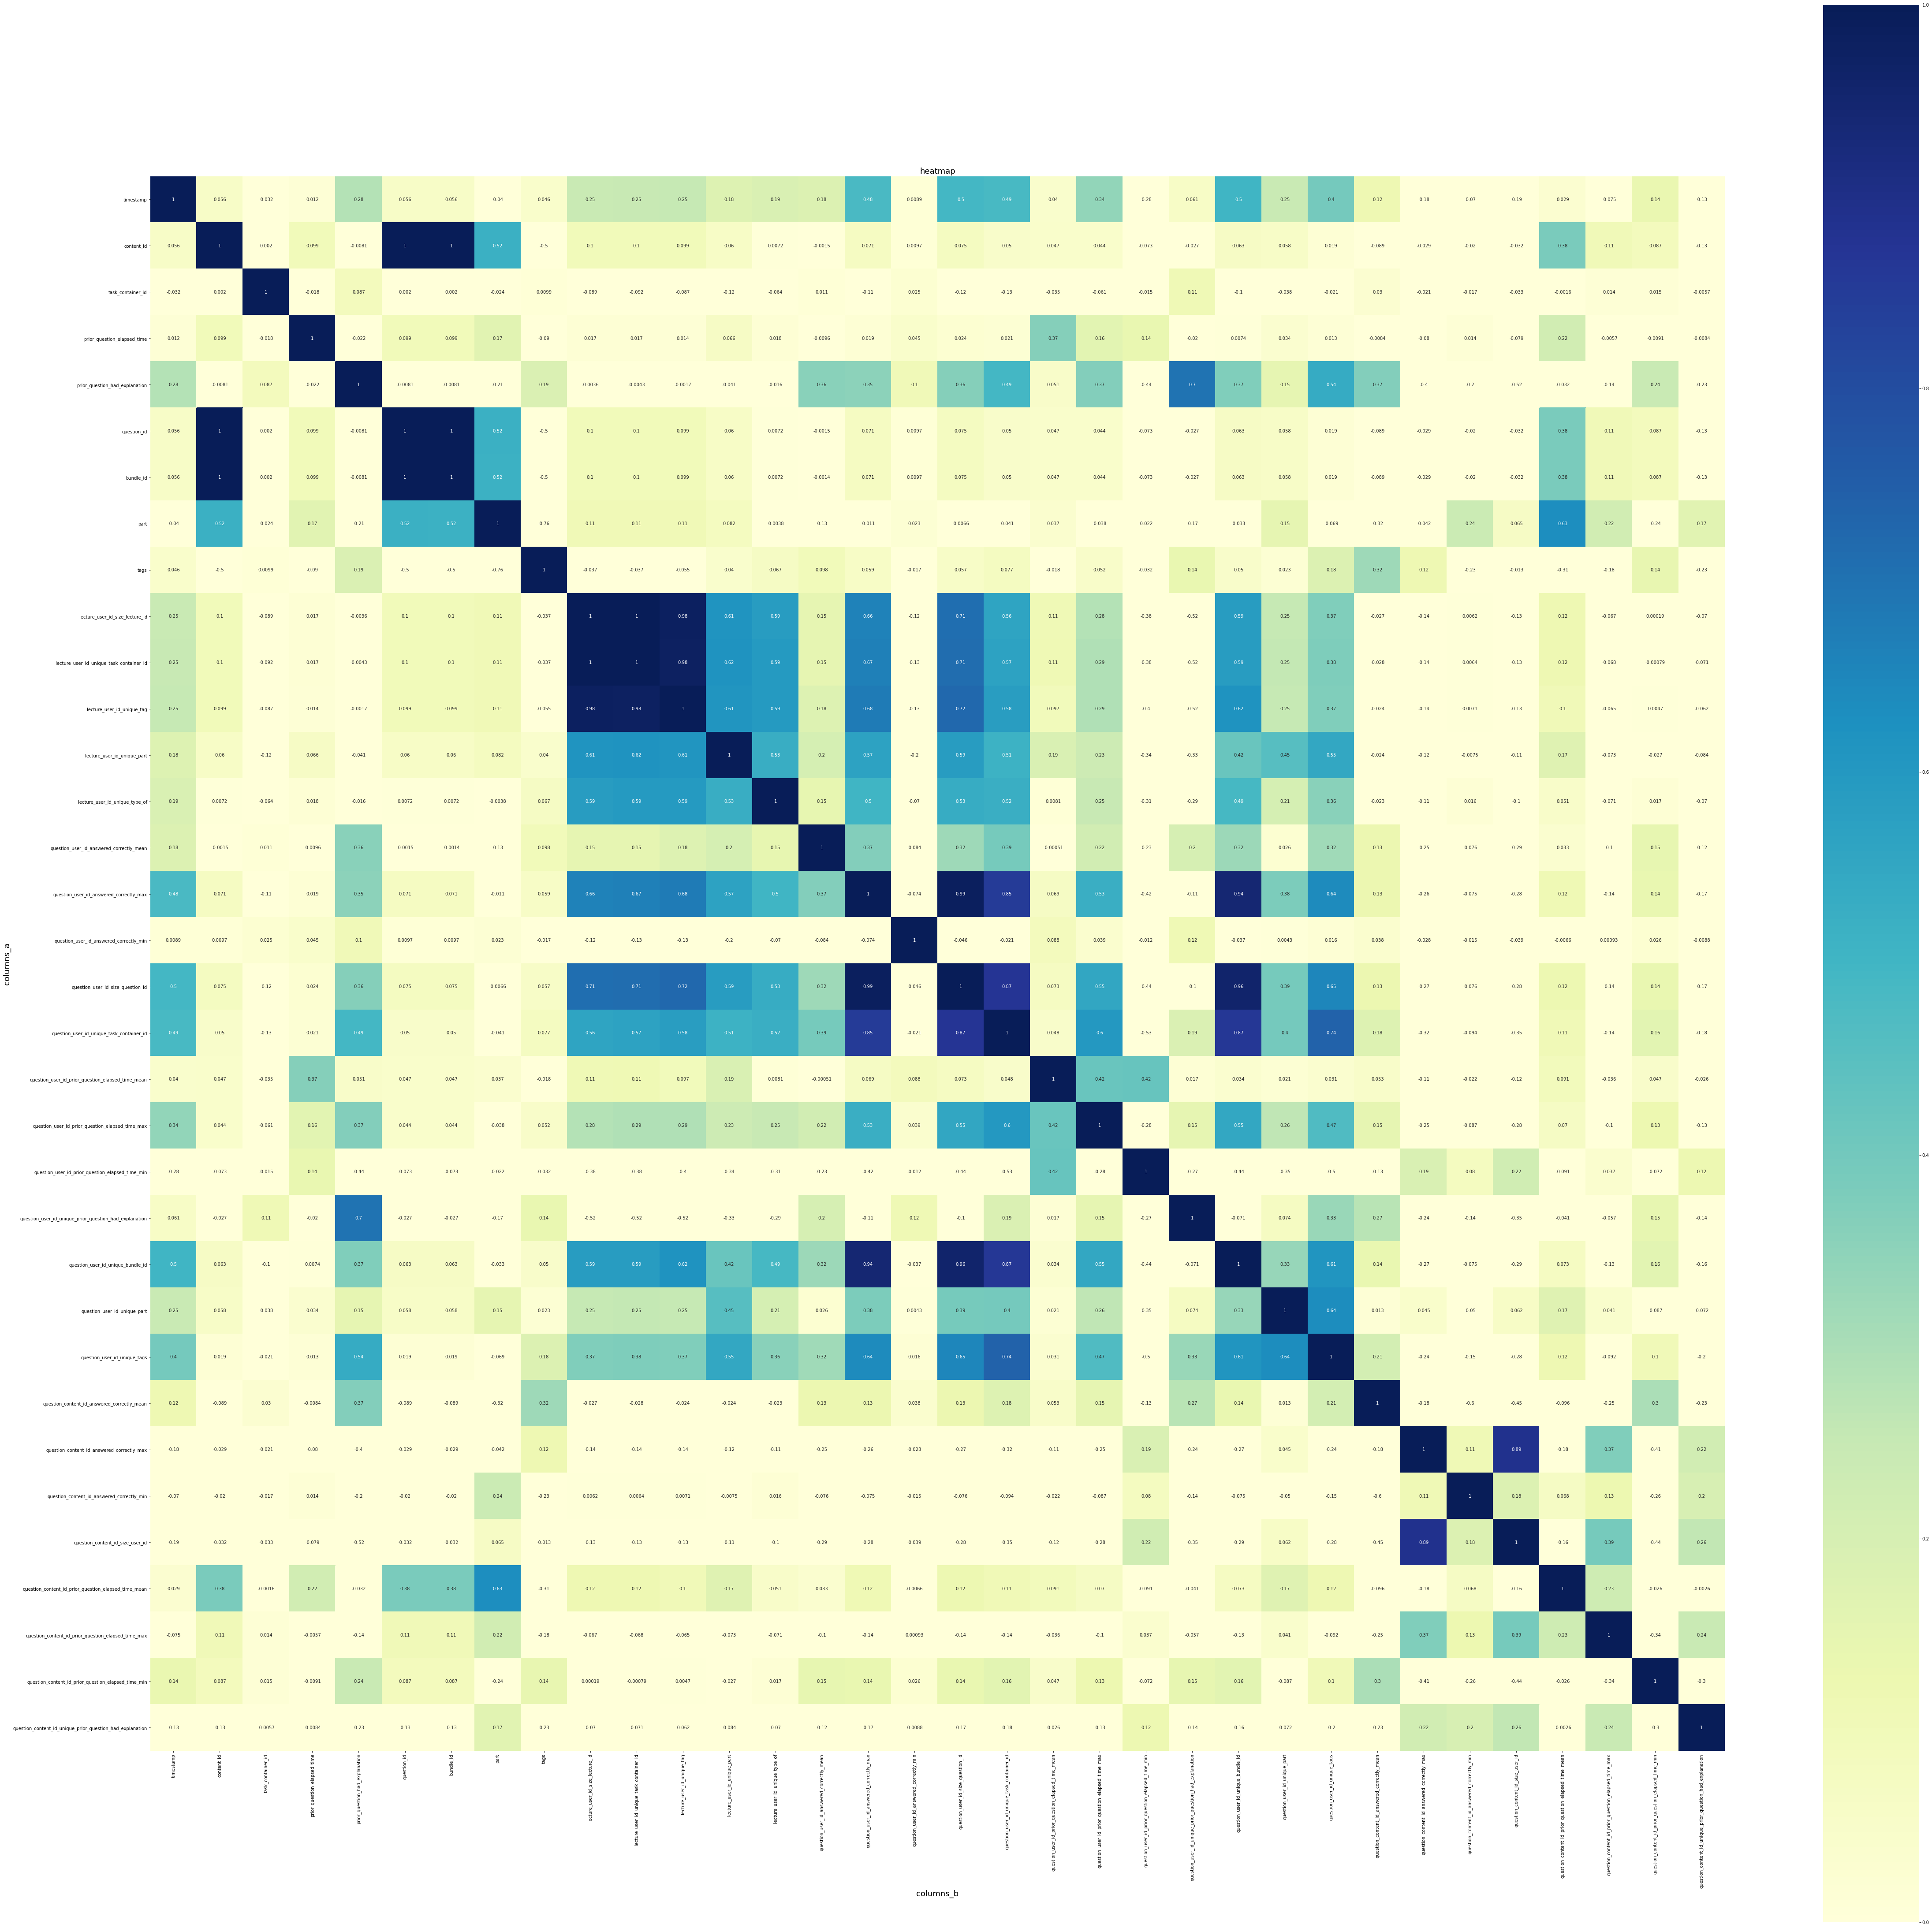

In [26]:
import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize = (80,80))

sns.heatmap(train_data[features_columns].corr(), 
                annot=True, vmax=1,vmin = 0, xticklabels= True, yticklabels= True, square=True, cmap="YlGnBu")

ax.set_title('heatmap', fontsize = 18)
ax.set_ylabel('columns_a', fontsize = 18)
ax.set_xlabel('columns_b', fontsize = 18) 

# 特征重要性

In [27]:
X_test, y_test = valid_data[features_columns].values, valid_data['answered_correctly'].values

X_train, y_train = train_data[features_columns].values, train_data['answered_correctly'].values

In [29]:
pd.DataFrame(y_train)

,0
0,1
1,0
2,0
3,1
4,0
...,...
37347,0
37348,0
37349,1
37350,1


In [28]:
params = {
    'task': 'train',
    'boosting_type': 'gbdt',
    'objective': 'binary',
    'metric': 'auc',
    'num_leaves': 9,
    'learning_rate': 0.3,
    'feature_fraction_seed': 2,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'min_data': 20,
    'min_hessian': 1,
    'verbose': -1,
    'silent': 0
    }

lgb_train = lgb.Dataset(X_train, y_train)
lgb_eval = lgb.Dataset(X_test, y_test, reference=lgb_train)

gbm = lgb.train(
            params,
            lgb_train,
            num_boost_round=10000,
            valid_sets=lgb_eval,
            early_stopping_rounds=20
            )

/root/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:1077: UserWarning: silent keyword has been found in `params` and will be ignored.
Please use silent argument of the Dataset constructor to pass this parameter.
  .format(key))


[LightGBM] [Warning] Unknown parameter: silent
[1]	valid_0's auc: 0.692392
Training until validation scores don't improve for 20 rounds
[2]	valid_0's auc: 0.706785
[3]	valid_0's auc: 0.708893
[4]	valid_0's auc: 0.710097
[5]	valid_0's auc: 0.711927
[6]	valid_0's auc: 0.712642
[7]	valid_0's auc: 0.714809
[8]	valid_0's auc: 0.716036
[9]	valid_0's auc: 0.716792
[10]	valid_0's auc: 0.717794
[11]	valid_0's auc: 0.718498
[12]	valid_0's auc: 0.718565
[13]	valid_0's auc: 0.718946
[14]	valid_0's auc: 0.719682
[15]	valid_0's auc: 0.719527
[16]	valid_0's auc: 0.720067
[17]	valid_0's auc: 0.720086
[18]	valid_0's auc: 0.720216
[19]	valid_0's auc: 0.72032
[20]	valid_0's auc: 0.720298
[21]	valid_0's auc: 0.720154
[22]	valid_0's auc: 0.720148
[23]	valid_0's auc: 0.720285
[24]	valid_0's auc: 0.72027
[25]	valid_0's auc: 0.720154
[26]	valid_0's auc: 0.720731
[27]	valid_0's auc: 0.720983
[28]	valid_0's auc: 0.720864
[29]	valid_0's auc: 0.721191
[30]	valid_0's auc: 0.721259
[31]	valid_0's auc: 0.7214
[32]	v

In [28]:
gbm.feature_importance()

array([21, 13, 12, 34,  3,  3,  4,  2,  0,  7,  4,  9,  3,  3, 35, 22, 26,
        9,  5, 13, 15, 15,  2, 18,  8,  2, 49, 21, 15, 14, 22, 17,  5,  1],
      dtype=int32)

In [29]:
len(features_columns)

34

In [30]:
gbm_features = pd.DataFrame({'feature_importance':gbm.feature_importance(),'features_columns':features_columns}).sort_values(['feature_importance'],ascending=0)
gbm_features

,feature_importance,features_columns
26,49,question_content_id_answered_correctly_mean
14,35,question_user_id_answered_correctly_mean
3,34,prior_question_elapsed_time
16,26,question_user_id_answered_correctly_min
15,22,question_user_id_answered_correctly_max
30,22,question_content_id_prior_question_elapsed_tim...
0,21,timestamp
27,21,question_content_id_answered_correctly_max
23,18,question_user_id_unique_bundle_id
31,17,question_content_id_prior_question_elapsed_tim...


<Figure size 7200x7200 with 0 Axes>

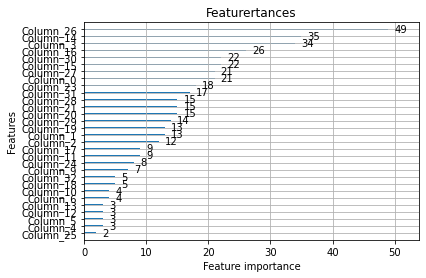

In [31]:
plt.figure(figsize=(100,100))
lgb.plot_importance(gbm, max_num_features=30)
plt.title("Featurertances")
plt.show()

# 交叉特征

In [32]:
X_test, y_test = valid_data[features_columns].values, valid_data['answered_correctly'].values
X_train, y_train = train_data[features_columns].values, train_data['answered_correctly'].values

In [33]:
epsilon=1e-5
func_dict = {
        'add': lambda x,y: x+y,
        'mins': lambda x,y: x-y,
        'div': lambda x,y: x/(y+epsilon),
        'multi': lambda x,y: x*y
        }

In [34]:
def cross_features(data, features_columns):
    df_cross_features = data.copy()
    for col_i in features_columns:
        for col_j in features_columns:
            for func_name, func in func_dict.items():
                    col_func_features = '-'.join([col_i,func_name,col_j])
                    df_cross_features[col_func_features] = func(data[col_i],data[col_j])
    return df_cross_features

In [35]:
train_cross_features = cross_features(train_data, features_columns)
test_cross_features = cross_features(valid_data, features_columns)

In [36]:
remove_columns = ['user_id','row_id','content_type_id','user_answer','answered_correctly','filter_row']
cross_features_columns = [c for c in train_cross_features.columns if c not in remove_columns]

In [37]:
cross_features_columns

['timestamp',
 'content_id',
 'task_container_id',
 'prior_question_elapsed_time',
 'prior_question_had_explanation',
 'question_id',
 'bundle_id',
 'part',
 'tags',
 'lecture_user_id_size_lecture_id',
 'lecture_user_id_unique_task_container_id',
 'lecture_user_id_unique_tag',
 'lecture_user_id_unique_part',
 'lecture_user_id_unique_type_of',
 'question_user_id_answered_correctly_mean',
 'question_user_id_answered_correctly_max',
 'question_user_id_answered_correctly_min',
 'question_user_id_size_question_id',
 'question_user_id_unique_task_container_id',
 'question_user_id_prior_question_elapsed_time_mean',
 'question_user_id_prior_question_elapsed_time_max',
 'question_user_id_prior_question_elapsed_time_min',
 'question_user_id_unique_prior_question_had_explanation',
 'question_user_id_unique_bundle_id',
 'question_user_id_unique_part',
 'question_user_id_unique_tags',
 'question_content_id_answered_correctly_mean',
 'question_content_id_answered_correctly_max',
 'question_content_i

In [38]:
len(cross_features_columns)

4658

In [39]:
X_test_cross, y_test_cross = test_cross_features[cross_features_columns].values, test_cross_features['answered_correctly'].values
X_train_cross, y_train_cross = train_cross_features[cross_features_columns].values, train_cross_features['answered_correctly'].values

In [40]:
params = {
    'task': 'train',
    'boosting_type': 'gbdt',
    'objective': 'binary',
    'metric': 'auc',
    'num_leaves': 9,
    'learning_rate': 0.3,
    'feature_fraction_seed': 2,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'min_data': 20,
    'min_hessian': 1,
    'verbose': -1,
    'silent': 0
    }

lgb_train = lgb.Dataset(X_train_cross, y_train_cross)
lgb_eval = lgb.Dataset(X_test_cross, y_test_cross, reference=lgb_train)

gbm = lgb.train(
            params,
            lgb_train,
            num_boost_round=10000,
            valid_sets=lgb_eval,
            early_stopping_rounds=20
            )

/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:842: UserWarning: silent keyword has been found in `params` and will be ignored.
Please use silent argument of the Dataset constructor to pass this parameter.
  .format(key))


[1]	valid_0's auc: 0.70516
Training until validation scores don't improve for 20 rounds
[2]	valid_0's auc: 0.713158
[3]	valid_0's auc: 0.714316
[4]	valid_0's auc: 0.716605
[5]	valid_0's auc: 0.717472
[6]	valid_0's auc: 0.718776
[7]	valid_0's auc: 0.719302
[8]	valid_0's auc: 0.720166
[9]	valid_0's auc: 0.720737
[10]	valid_0's auc: 0.721215
[11]	valid_0's auc: 0.721394
[12]	valid_0's auc: 0.721545
[13]	valid_0's auc: 0.722167
[14]	valid_0's auc: 0.721591
[15]	valid_0's auc: 0.721453
[16]	valid_0's auc: 0.721397
[17]	valid_0's auc: 0.721691
[18]	valid_0's auc: 0.721892
[19]	valid_0's auc: 0.721958
[20]	valid_0's auc: 0.721871
[21]	valid_0's auc: 0.722191
[22]	valid_0's auc: 0.72199
[23]	valid_0's auc: 0.721946
[24]	valid_0's auc: 0.722169
[25]	valid_0's auc: 0.722057
[26]	valid_0's auc: 0.721992
[27]	valid_0's auc: 0.722378
[28]	valid_0's auc: 0.722374
[29]	valid_0's auc: 0.722303
[30]	valid_0's auc: 0.722115
[31]	valid_0's auc: 0.722103
[32]	valid_0's auc: 0.721981
[33]	valid_0's auc: 0.

# 特征筛选

In [41]:
gbm_cross_features = pd.DataFrame({'cross_feature_importance':gbm.feature_importance(),'cross_features_columns':cross_features_columns}).sort_values(['cross_feature_importance'],ascending=0)
gbm_cross_features

,cross_feature_importance,cross_features_columns
2042,14,question_user_id_answered_correctly_mean-add-q...
2045,5,question_user_id_answered_correctly_mean-multi...
2052,4,question_user_id_answered_correctly_mean-div-q...
3692,3,question_content_id_answered_correctly_mean-di...
3400,3,question_user_id_unique_part-div-question_user...
...,...,...
1584,0,lecture_user_id_unique_tag-div-lecture_user_id...
1585,0,lecture_user_id_unique_tag-multi-lecture_user_...
1586,0,lecture_user_id_unique_tag-add-question_user_i...
1587,0,lecture_user_id_unique_tag-mins-question_user_...


In [42]:
df_select = gbm_cross_features[gbm_cross_features['cross_feature_importance']>0]
df_select

,cross_feature_importance,cross_features_columns
2042,14,question_user_id_answered_correctly_mean-add-q...
2045,5,question_user_id_answered_correctly_mean-multi...
2052,4,question_user_id_answered_correctly_mean-div-q...
3692,3,question_content_id_answered_correctly_mean-di...
3400,3,question_user_id_unique_part-div-question_user...
...,...,...
3017,1,question_user_id_prior_question_elapsed_time_m...
3011,1,question_user_id_prior_question_elapsed_time_m...
2070,1,question_user_id_answered_correctly_mean-add-q...
415,1,task_container_id-mins-question_content_id_ans...


In [43]:
features_select = df_select['cross_features_columns'].to_list()
features_select

['question_user_id_answered_correctly_mean-add-question_content_id_answered_correctly_mean',
 'question_user_id_answered_correctly_mean-multi-question_content_id_answered_correctly_mean',
 'question_user_id_answered_correctly_mean-div-question_content_id_answered_correctly_min',
 'question_content_id_answered_correctly_mean-div-question_content_id_prior_question_elapsed_time_mean',
 'question_user_id_unique_part-div-question_user_id_unique_tags',
 'question_user_id_prior_question_elapsed_time_mean-multi-question_content_id_prior_question_elapsed_time_mean',
 'question_user_id_answered_correctly_mean-div-question_user_id_unique_tags',
 'question_user_id_prior_question_elapsed_time_min-add-question_content_id_prior_question_elapsed_time_mean',
 'question_content_id_answered_correctly_mean-div-question_content_id_unique_prior_question_had_explanation',
 'part-multi-question_user_id_prior_question_elapsed_time_mean',
 'question_user_id_answered_correctly_min-add-question_user_id_unique_par

In [44]:
# [1,2,3,4]
# [1]
# [1,2]
# [1,2,3]

In [45]:
for i,_ in enumerate(features_select):
    cross_features_columns_i = features_select[:i]
    X_test_cross_i, y_test_cross_i = test_cross_features[cross_features_columns_i].values, test_cross_features['answered_correctly'].values
    X_train_cross_i, y_train_cross_i = train_cross_features[cross_features_columns_i].values, train_cross_features['answered_correctly'].values

    print('--------------------------')
    print('cross_features : ' + str(i))
    params = {
    'task': 'train',
    'boosting_type': 'gbdt',
    'objective': 'binary',
    'metric': 'auc',
    'num_leaves': 9,
    'learning_rate': 0.3,
    'feature_fraction_seed': 2,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'min_data': 20,
    'min_hessian': 1,
    'verbose': -1,
    'silent': 0
    }

    lgb_train = lgb.Dataset(X_train_cross_i, y_train_cross_i)
    lgb_eval = lgb.Dataset(X_test_cross_i, y_test_cross_i, reference=lgb_train)

    gbm = lgb.train(
                params,
                lgb_train,
                num_boost_round=10000,
                valid_sets=lgb_eval,
                early_stopping_rounds=20
                )
    print('cross_features : ' + str(i))
    print('--------------------------')

--------------------------
cross_features : 0
[1]	valid_0's auc: 0.5
Training until validation scores don't improve for 20 rounds
[2]	valid_0's auc: 0.5
[3]	valid_0's auc: 0.5
[4]	valid_0's auc: 0.5
[5]	valid_0's auc: 0.5
[6]	valid_0's auc: 0.5
[7]	valid_0's auc: 0.5
[8]	valid_0's auc: 0.5
[9]	valid_0's auc: 0.5
[10]	valid_0's auc: 0.5
[11]	valid_0's auc: 0.5
[12]	valid_0's auc: 0.5
[13]	valid_0's auc: 0.5
[14]	valid_0's auc: 0.5
[15]	valid_0's auc: 0.5
[16]	valid_0's auc: 0.5
[17]	valid_0's auc: 0.5
[18]	valid_0's auc: 0.5
[19]	valid_0's auc: 0.5
[20]	valid_0's auc: 0.5
[21]	valid_0's auc: 0.5
Early stopping, best iteration is:
[1]	valid_0's auc: 0.5


/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:842: UserWarning: silent keyword has been found in `params` and will be ignored.
Please use silent argument of the Dataset constructor to pass this parameter.
  .format(key))


cross_features : 0
--------------------------
--------------------------
cross_features : 1
[1]	valid_0's auc: 0.708307
Training until validation scores don't improve for 20 rounds
[2]	valid_0's auc: 0.710343
[3]	valid_0's auc: 0.710484
[4]	valid_0's auc: 0.710859
[5]	valid_0's auc: 0.71114
[6]	valid_0's auc: 0.711398
[7]	valid_0's auc: 0.711224
[8]	valid_0's auc: 0.711264
[9]	valid_0's auc: 0.711259
[10]	valid_0's auc: 0.710971
[11]	valid_0's auc: 0.711091
[12]	valid_0's auc: 0.710889
[13]	valid_0's auc: 0.710981
[14]	valid_0's auc: 0.710972
[15]	valid_0's auc: 0.710878
[16]	valid_0's auc: 0.710842
[17]	valid_0's auc: 0.710739
[18]	valid_0's auc: 0.710759
[19]	valid_0's auc: 0.710663
[20]	valid_0's auc: 0.710598
[21]	valid_0's auc: 0.710336
[22]	valid_0's auc: 0.710326
[23]	valid_0's auc: 0.710232
[24]	valid_0's auc: 0.710047
[25]	valid_0's auc: 0.709989
[26]	valid_0's auc: 0.709905
Early stopping, best iteration is:
[6]	valid_0's auc: 0.711398
cross_features : 1
---------------------

In [46]:
 gbm.best_score['valid_0']['auc']

0.7226841306039259

# 贝叶斯调参

In [47]:
from bayes_opt import BayesianOptimization

In [49]:
def black_box_function(x, y):
    """Function with unknown internals we wish to maximize.

    This is just serving as an example, for all intents and
    purposes think of the internals of this function, i.e.: the process
    which generates its output values, as unknown.
    """
    return -x ** 2 - (y - 1) ** 2 + 1

In [50]:
# Bounded region of parameter space
pbounds = {'x': (2, 4), 'y': (-3, 3)}

optimizer = BayesianOptimization(
    f=black_box_function,
    pbounds=pbounds,
    random_state=1,
)

In [51]:
optimizer.maximize(
    init_points=2,
    n_iter=3,
)

|   iter    |  target   |     x     |     y     |
-------------------------------------------------
|  1        | -7.135    |  2.834    |  1.322    |
|  2        | -7.78     |  2.0      | -1.186    |
|  3        | -7.11     |  2.218    | -0.7867   |
|  4        | -12.4     |  3.66     |  0.9608   |
|  5        | -6.999    |  2.23     | -0.7392   |


In [52]:
def lgb_auc(feature_fraction, bagging_fraction):
    
    params = {
    'task': 'train',
    'boosting_type': 'gbdt',
    'objective': 'binary',
    'metric': 'auc',
    'num_leaves': 9,
    'learning_rate': 0.3,
    'feature_fraction_seed': 2,
    'feature_fraction': feature_fraction,
    'bagging_fraction': bagging_fraction,
    'bagging_freq': 5,
    'min_data': 20,
    'min_hessian': 1,
    'verbose': -1,
    'silent': 1
    }

    lgb_train = lgb.Dataset(X_train, y_train)
    lgb_eval = lgb.Dataset(X_test, y_test, reference=lgb_train)

    gbm = lgb.train(
                params,
                lgb_train,
                num_boost_round=10000,
                valid_sets=lgb_eval,
                early_stopping_rounds=20
                )
    return  gbm.best_score['valid_0']['auc']

In [53]:
pbounds = {'feature_fraction': (0, 1), 'bagging_fraction': (0, 1)}

optimizer = BayesianOptimization(
    f=lgb_auc,
    pbounds=pbounds,
    random_state=1,
)

In [54]:
optimizer.maximize(
    init_points=2,
    n_iter=3,
)

|   iter    |  target   | baggin... | featur... |
-------------------------------------------------
[1]	valid_0's auc: 0.683699
Training until validation scores don't improve for 20 rounds
[2]	valid_0's auc: 0.702797
[3]	valid_0's auc: 0.709934
[4]	valid_0's auc: 0.7095


/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:842: UserWarning: silent keyword has been found in `params` and will be ignored.
Please use silent argument of the Dataset constructor to pass this parameter.
  .format(key))


[5]	valid_0's auc: 0.71221
[6]	valid_0's auc: 0.713928
[7]	valid_0's auc: 0.714974
[8]	valid_0's auc: 0.714577
[9]	valid_0's auc: 0.714795
[10]	valid_0's auc: 0.716103
[11]	valid_0's auc: 0.716607
[12]	valid_0's auc: 0.717024
[13]	valid_0's auc: 0.716864
[14]	valid_0's auc: 0.7171
[15]	valid_0's auc: 0.717264
[16]	valid_0's auc: 0.717617
[17]	valid_0's auc: 0.717456
[18]	valid_0's auc: 0.717806
[19]	valid_0's auc: 0.717865
[20]	valid_0's auc: 0.717744
[21]	valid_0's auc: 0.717411
[22]	valid_0's auc: 0.717481
[23]	valid_0's auc: 0.717728
[24]	valid_0's auc: 0.717362
[25]	valid_0's auc: 0.71713
[26]	valid_0's auc: 0.717014
[27]	valid_0's auc: 0.716479
[28]	valid_0's auc: 0.716706
[29]	valid_0's auc: 0.716643
[30]	valid_0's auc: 0.716363
[31]	valid_0's auc: 0.716647
[32]	valid_0's auc: 0.717268
[33]	valid_0's auc: 0.717228
[34]	valid_0's auc: 0.717425
[35]	valid_0's auc: 0.717315
[36]	valid_0's auc: 0.717346
[37]	valid_0's auc: 0.717132
[38]	valid_0's auc: 0.717226
[39]	valid_0's auc: 0.7

/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:842: UserWarning: silent keyword has been found in `params` and will be ignored.
Please use silent argument of the Dataset constructor to pass this parameter.
  .format(key))


[1]	valid_0's auc: 0.683699
Training until validation scores don't improve for 20 rounds
[2]	valid_0's auc: 0.701317
[3]	valid_0's auc: 0.710559
[4]	valid_0's auc: 0.710597
[5]	valid_0's auc: 0.71246
[6]	valid_0's auc: 0.71354
[7]	valid_0's auc: 0.713524
[8]	valid_0's auc: 0.712681
[9]	valid_0's auc: 0.713025
[10]	valid_0's auc: 0.713865
[11]	valid_0's auc: 0.714858
[12]	valid_0's auc: 0.715452
[13]	valid_0's auc: 0.715691
[14]	valid_0's auc: 0.716081
[15]	valid_0's auc: 0.716049
[16]	valid_0's auc: 0.716294
[17]	valid_0's auc: 0.716379
[18]	valid_0's auc: 0.715982
[19]	valid_0's auc: 0.717309
[20]	valid_0's auc: 0.717129
[21]	valid_0's auc: 0.717239
[22]	valid_0's auc: 0.717121
[23]	valid_0's auc: 0.717332
[24]	valid_0's auc: 0.717295
[25]	valid_0's auc: 0.717172
[26]	valid_0's auc: 0.716941
[27]	valid_0's auc: 0.717423
[28]	valid_0's auc: 0.717413
[29]	valid_0's auc: 0.716961
[30]	valid_0's auc: 0.717054
[31]	valid_0's auc: 0.717074
[32]	valid_0's auc: 0.717209
[33]	valid_0's auc: 0.

/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:842: UserWarning: silent keyword has been found in `params` and will be ignored.
Please use silent argument of the Dataset constructor to pass this parameter.
  .format(key))


[1]	valid_0's auc: 0.682855
Training until validation scores don't improve for 20 rounds
[2]	valid_0's auc: 0.70144
[3]	valid_0's auc: 0.707562
[4]	valid_0's auc: 0.708535
[5]	valid_0's auc: 0.712116
[6]	valid_0's auc: 0.712126
[7]	valid_0's auc: 0.713236
[8]	valid_0's auc: 0.714722
[9]	valid_0's auc: 0.716038
[10]	valid_0's auc: 0.71718
[11]	valid_0's auc: 0.717889
[12]	valid_0's auc: 0.718435
[13]	valid_0's auc: 0.719175
[14]	valid_0's auc: 0.719517
[15]	valid_0's auc: 0.71979
[16]	valid_0's auc: 0.719786
[17]	valid_0's auc: 0.719944
[18]	valid_0's auc: 0.720191
[19]	valid_0's auc: 0.720196
[20]	valid_0's auc: 0.720427
[21]	valid_0's auc: 0.720696
[22]	valid_0's auc: 0.720581
[23]	valid_0's auc: 0.720617
[24]	valid_0's auc: 0.720595
[25]	valid_0's auc: 0.72059
[26]	valid_0's auc: 0.72053
[27]	valid_0's auc: 0.720387
[28]	valid_0's auc: 0.720712
[29]	valid_0's auc: 0.720489
[30]	valid_0's auc: 0.720249
[31]	valid_0's auc: 0.72023
[32]	valid_0's auc: 0.720294
[33]	valid_0's auc: 0.7202

/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:842: UserWarning: silent keyword has been found in `params` and will be ignored.
Please use silent argument of the Dataset constructor to pass this parameter.
  .format(key))


[1]	valid_0's auc: 0.682855
Training until validation scores don't improve for 20 rounds
[2]	valid_0's auc: 0.701273
[3]	valid_0's auc: 0.706939
[4]	valid_0's auc: 0.708037
[5]	valid_0's auc: 0.712439
[6]	valid_0's auc: 0.712273
[7]	valid_0's auc: 0.711854
[8]	valid_0's auc: 0.712378
[9]	valid_0's auc: 0.715546
[10]	valid_0's auc: 0.716245
[11]	valid_0's auc: 0.716706
[12]	valid_0's auc: 0.717195
[13]	valid_0's auc: 0.718653
[14]	valid_0's auc: 0.719087
[15]	valid_0's auc: 0.719206
[16]	valid_0's auc: 0.719498
[17]	valid_0's auc: 0.719532
[18]	valid_0's auc: 0.719726
[19]	valid_0's auc: 0.720495
[20]	valid_0's auc: 0.720903
[21]	valid_0's auc: 0.720907
[22]	valid_0's auc: 0.720862
[23]	valid_0's auc: 0.720907
[24]	valid_0's auc: 0.720918
[25]	valid_0's auc: 0.720792
[26]	valid_0's auc: 0.720673
[27]	valid_0's auc: 0.720915
[28]	valid_0's auc: 0.721219
[29]	valid_0's auc: 0.721127
[30]	valid_0's auc: 0.721131
[31]	valid_0's auc: 0.721082
[32]	valid_0's auc: 0.721018
[33]	valid_0's auc: 

In [ ]:
|   iter    |  target   | baggin... | featur... |
|  1        |  0.7179   |  0.417    |  0.7203   |
|  2        |  0.5      |  0.000114 |  0.3023   |
|  3        |  0.7174   |  0.415    |  0.725    |
|  4        |  0.7207   |  0.8995   |  0.7892   |
|  5        |  0.7212   |  0.9008   |  0.7883   |

In [55]:
bayes_opt_best_params = {
    'task': 'train',
    'boosting_type': 'gbdt',
    'objective': 'binary',
    'metric': 'auc',
    'num_leaves': 9,
    'learning_rate': 0.3,
    'feature_fraction_seed': 2,
    'feature_fraction': 0.7883, # bayes_opt
    'bagging_fraction': 0.9008, # bayes_opt
    'bagging_freq': 5,
    'min_data': 20,
    'min_hessian': 1,
    'verbose': -1,
    'silent': 1
    }


# grid cv params 搜索

In [59]:
best = []
for feature_fraction_i in range(10):
    feature_fraction_i = feature_fraction_i / 10.0
    for bagging_fraction_j in range(10):
        bagging_fraction_j = bagging_fraction_j / 10.0 
        
        grid_cv_params = {
        'task': 'train',
        'boosting_type': 'gbdt',
        'objective': 'binary',
        'metric': 'auc',
        'num_leaves': 9,
        'learning_rate': 0.3,
        'feature_fraction_seed': 2,
        'feature_fraction': feature_fraction_i, 
        'bagging_fraction': bagging_fraction_j, 
        'bagging_freq': 5,
        'min_data': 20,
        'min_hessian': 1,
        'verbose': -1,
        'silent': 1
        }
    lgb_train = lgb.Dataset(X_train, y_train)
    lgb_eval = lgb.Dataset(X_test, y_test, reference=lgb_train)

    gbm = lgb.train(
                params,
                lgb_train,
                num_boost_round=10000,
                valid_sets=lgb_eval,
                early_stopping_rounds=20
                )
    print(
        'feature_fraction : ',feature_fraction_i,
        'bagging_fraction : ',bagging_fraction_j,
        'auc : ',gbm.best_score['valid_0']['auc']
    )
    best += [('feature_fraction : ',feature_fraction_i,
        'bagging_fraction : ',bagging_fraction_j,
        'auc : ',gbm.best_score['valid_0']['auc'])]

[1]	valid_0's auc: 0.682505
Training until validation scores don't improve for 20 rounds
[2]	valid_0's auc: 0.701407
[3]	valid_0's auc: 0.707003
[4]	valid_0's auc: 0.710099
[5]	valid_0's auc: 0.712246
[6]	valid_0's auc: 0.713347
[7]	valid_0's auc: 0.713788
[8]	valid_0's auc: 0.71459
[9]	valid_0's auc: 0.715957
[10]	valid_0's auc: 0.716524
[11]	valid_0's auc: 0.718018
[12]	valid_0's auc: 0.718012
[13]	valid_0's auc: 0.718045
[14]	valid_0's auc: 0.71841
[15]	valid_0's auc: 0.718751
[16]	valid_0's auc: 0.71954
[17]	valid_0's auc: 0.719831
[18]	valid_0's auc: 0.719717
[19]	valid_0's auc: 0.719782
[20]	valid_0's auc: 0.719895
[21]	valid_0's auc: 0.719933
[22]	valid_0's auc: 0.72016
[23]	valid_0's auc: 0.720052
[24]	valid_0's auc: 0.720353
[25]	valid_0's auc: 0.720405
[26]	valid_0's auc: 0.720199
[27]	valid_0's auc: 0.720179
[28]	valid_0's auc: 0.719988
[29]	valid_0's auc: 0.719848
[30]	valid_0's auc: 0.719755
[31]	valid_0's auc: 0.719667
[32]	valid_0's auc: 0.71975
[33]	valid_0's auc: 0.719

In [61]:
# best

# Stacking实战

In [62]:

# -*- coding: utf-8 -*-
###########################################################
# 提交的代码
import pandas as pd
import numpy as np
import lightgbm as lgb
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold

class SBBTree():
    """Stacking,Bootstap,Bagging----SBBTree"""
    """ author：Cookly """
    def __init__(self, params, stacking_num, bagging_num, bagging_test_size, num_boost_round, early_stopping_rounds):
        """
        Initializes the SBBTree.
        Args:
          params : lgb params.
          stacking_num : k_flod stacking.
          bagging_num : bootstrap num.
          bagging_test_size : bootstrap sample rate.
          num_boost_round : boost num.
          early_stopping_rounds : early_stopping_rounds.
        """
        self.params = params
        self.stacking_num = stacking_num
        self.bagging_num = bagging_num
        self.bagging_test_size = bagging_test_size
        self.num_boost_round = num_boost_round
        self.early_stopping_rounds = early_stopping_rounds

        self.model = lgb
        self.stacking_model = []
        self.bagging_model = []

    def fit(self, X, y):
        """ fit model. """
        if self.stacking_num > 1:
            layer_train = np.zeros((X.shape[0], 2))
            self.SK = StratifiedKFold(n_splits=self.stacking_num, shuffle=True, random_state=1)
            for k,(train_index, test_index) in enumerate(self.SK.split(X, y)):
                X_train = X[train_index]
                y_train = y[train_index]
                X_test = X[test_index]
                y_test = y[test_index]

                lgb_train = lgb.Dataset(X_train, y_train)
                lgb_eval = lgb.Dataset(X_test, y_test, reference=lgb_train)

                gbm = lgb.train(self.params,
                            lgb_train,
                            num_boost_round=self.num_boost_round,
                            valid_sets=lgb_eval,
                            early_stopping_rounds=self.early_stopping_rounds)

                self.stacking_model.append(gbm)

                pred_y = gbm.predict(X_test, num_iteration=gbm.best_iteration)
                layer_train[test_index, 1] = pred_y

            X = np.hstack((X, layer_train[:,1].reshape((-1,1)))) 
        else:
            pass
        for bn in range(self.bagging_num):
            X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=self.bagging_test_size, random_state=bn)

            lgb_train = lgb.Dataset(X_train, y_train)
            lgb_eval = lgb.Dataset(X_test, y_test, reference=lgb_train)

            gbm = lgb.train(params,
                        lgb_train,
                        num_boost_round=10000,
                        valid_sets=lgb_eval,
                        early_stopping_rounds=200)

            self.bagging_model.append(gbm)

    def predict(self, X_pred):
        """ predict test data. """
        if self.stacking_num > 1:
            test_pred = np.zeros((X_pred.shape[0], self.stacking_num))
            for sn,gbm in enumerate(self.stacking_model):
                pred = gbm.predict(X_pred, num_iteration=gbm.best_iteration)
                test_pred[:, sn] = pred
            X_pred = np.hstack((X_pred, test_pred.mean(axis=1).reshape((-1,1))))  
        else:
            pass 
        for bn,gbm in enumerate(self.bagging_model):
            pred = gbm.predict(X_pred, num_iteration=gbm.best_iteration)
            if bn == 0:
                pred_out=pred
            else:
                pred_out+=pred
        return pred_out/self.bagging_num

###########################################################################
# test code
from sklearn.datasets import make_classification
from sklearn.datasets import load_breast_cancer
from sklearn.datasets import make_gaussian_quantiles
from sklearn import metrics
from sklearn.metrics import f1_score
# X, y = make_classification(n_samples=1000, n_features=25, n_clusters_per_class=1, n_informative=15, random_state=1)
X, y = make_gaussian_quantiles(mean=None, cov=1.0, n_samples=1000, n_features=50, n_classes=2, shuffle=True, random_state=2)
# data = load_breast_cancer()
# X, y = data.data, data.target
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=1)
params = {
        'task': 'train',
        'boosting_type': 'gbdt',
        'objective': 'binary',
        'metric': 'auc',
        'num_leaves': 9,
        'learning_rate': 0.03,
        'feature_fraction_seed': 2,
        'feature_fraction': 0.9,
        'bagging_fraction': 0.8,
        'bagging_freq': 5,
        'min_data': 20,
        'min_hessian': 1,
        'verbose': -1,
        'silent': 0
        }
# test 1
model = SBBTree(params=params, stacking_num=2, bagging_num=1,  bagging_test_size=0.33, num_boost_round=10000, early_stopping_rounds=200)
model.fit(X,y)
X_pred = X[0].reshape((1,-1))
pred=model.predict(X_pred)
print('pred')
print(pred)
print('TEST 1 ok')

'''
# test 1
model = SBBTree(params, stacking_num=1, bagging_num=1, bagging_test_size=0.33, num_boost_round=10000, early_stopping_rounds=200)
model.fit(X_train,y_train)
pred1=model.predict(X_test)
# test 2 
model = SBBTree(params, stacking_num=1, bagging_num=3, bagging_test_size=0.33, num_boost_round=10000, early_stopping_rounds=200)
model.fit(X_train,y_train)
pred2=model.predict(X_test)
# test 3 
model = SBBTree(params, stacking_num=5, bagging_num=1, bagging_test_size=0.33, num_boost_round=10000, early_stopping_rounds=200)
model.fit(X_train,y_train)
pred3=model.predict(X_test)
# test 4 
model = SBBTree(params, stacking_num=5, bagging_num=3, bagging_test_size=0.33, num_boost_round=10000, early_stopping_rounds=200)
model.fit(X_train,y_train)
pred4=model.predict(X_test)
fpr, tpr, thresholds = metrics.roc_curve(y_test+1, pred1, pos_label=2)
print('auc: ',metrics.auc(fpr, tpr))
fpr, tpr, thresholds = metrics.roc_curve(y_test+1, pred2, pos_label=2)
print('auc: ',metrics.auc(fpr, tpr))
fpr, tpr, thresholds = metrics.roc_curve(y_test+1, pred3, pos_label=2)
print('auc: ',metrics.auc(fpr, tpr))
fpr, tpr, thresholds = metrics.roc_curve(y_test+1, pred4, pos_label=2)
print('auc: ',metrics.auc(fpr, tpr))
'''

/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:842: UserWarning: silent keyword has been found in `params` and will be ignored.
Please use silent argument of the Dataset constructor to pass this parameter.
  .format(key))


[1]	valid_0's auc: 0.589432
Training until validation scores don't improve for 200 rounds
[2]	valid_0's auc: 0.59292
[3]	valid_0's auc: 0.59092
[4]	valid_0's auc: 0.61048
[5]	valid_0's auc: 0.611936
[6]	valid_0's auc: 0.610368
[7]	valid_0's auc: 0.611112
[8]	valid_0's auc: 0.613168
[9]	valid_0's auc: 0.6156
[10]	valid_0's auc: 0.620088
[11]	valid_0's auc: 0.624968
[12]	valid_0's auc: 0.625864
[13]	valid_0's auc: 0.620952
[14]	valid_0's auc: 0.622024
[15]	valid_0's auc: 0.616968
[16]	valid_0's auc: 0.615464
[17]	valid_0's auc: 0.614152
[18]	valid_0's auc: 0.611928
[19]	valid_0's auc: 0.61068
[20]	valid_0's auc: 0.614656
[21]	valid_0's auc: 0.617568
[22]	valid_0's auc: 0.622752
[23]	valid_0's auc: 0.624368
[24]	valid_0's auc: 0.630704
[25]	valid_0's auc: 0.633136
[26]	valid_0's auc: 0.632496
[27]	valid_0's auc: 0.631648
[28]	valid_0's auc: 0.634224
[29]	valid_0's auc: 0.636512
[30]	valid_0's auc: 0.635392
[31]	valid_0's auc: 0.63744
[32]	valid_0's auc: 0.639216
[33]	valid_0's auc: 0.6389

"\n# test 1\nmodel = SBBTree(params, stacking_num=1, bagging_num=1, bagging_test_size=0.33, num_boost_round=10000, early_stopping_rounds=200)\nmodel.fit(X_train,y_train)\npred1=model.predict(X_test)\n# test 2 \nmodel = SBBTree(params, stacking_num=1, bagging_num=3, bagging_test_size=0.33, num_boost_round=10000, early_stopping_rounds=200)\nmodel.fit(X_train,y_train)\npred2=model.predict(X_test)\n# test 3 \nmodel = SBBTree(params, stacking_num=5, bagging_num=1, bagging_test_size=0.33, num_boost_round=10000, early_stopping_rounds=200)\nmodel.fit(X_train,y_train)\npred3=model.predict(X_test)\n# test 4 \nmodel = SBBTree(params, stacking_num=5, bagging_num=3, bagging_test_size=0.33, num_boost_round=10000, early_stopping_rounds=200)\nmodel.fit(X_train,y_train)\npred4=model.predict(X_test)\nfpr, tpr, thresholds = metrics.roc_curve(y_test+1, pred1, pos_label=2)\nprint('auc: ',metrics.auc(fpr, tpr))\nfpr, tpr, thresholds = metrics.roc_curve(y_test+1, pred2, pos_label=2)\nprint('auc: ',metrics.au

In [63]:
# test 1
model = SBBTree(params, stacking_num=1, bagging_num=1, bagging_test_size=0.33, num_boost_round=10000, early_stopping_rounds=200)
model.fit(X_train,y_train)
pred1=model.predict(X_test)

[1]	valid_0's auc: 0.606347
Training until validation scores don't improve for 200 rounds
[2]	valid_0's auc: 0.587379
[3]	valid_0's auc: 0.595089
[4]	valid_0's auc: 0.586481
[5]	valid_0's auc: 0.586359
[6]	valid_0's auc: 0.600432
[7]	valid_0's auc: 0.60753
[8]	valid_0's auc: 0.611936
[9]	valid_0's auc: 0.611324
[10]	valid_0's auc: 0.615893
[11]	valid_0's auc: 0.613119
[12]	valid_0's auc: 0.605858
[13]	valid_0's auc: 0.602023
[14]	valid_0's auc: 0.592886
[15]	valid_0's auc: 0.608469
[16]	valid_0's auc: 0.606837
[17]	valid_0's auc: 0.610345
[18]	valid_0's auc: 0.609121
[19]	valid_0's auc: 0.609692
[20]	valid_0's auc: 0.614098
[21]	valid_0's auc: 0.621686
[22]	valid_0's auc: 0.620543
[23]	valid_0's auc: 0.627478
[24]	valid_0's auc: 0.636697
[25]	valid_0's auc: 0.64045
[26]	valid_0's auc: 0.63376
[27]	valid_0's auc: 0.642
[28]	valid_0's auc: 0.6389
[29]	valid_0's auc: 0.640206
[30]	valid_0's auc: 0.638003
[31]	valid_0's auc: 0.642164
[32]	valid_0's auc: 0.645835
[33]	valid_0's auc: 0.64901

In [64]:
# test 3 
model = SBBTree(params, stacking_num=5, bagging_num=1, bagging_test_size=0.33, num_boost_round=10000, early_stopping_rounds=200)
model.fit(X_train,y_train)
pred3=model.predict(X_test)

/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:842: UserWarning: silent keyword has been found in `params` and will be ignored.
Please use silent argument of the Dataset constructor to pass this parameter.
  .format(key))


[1]	valid_0's auc: 0.56767
Training until validation scores don't improve for 200 rounds
[2]	valid_0's auc: 0.613266
[3]	valid_0's auc: 0.623746
[4]	valid_0's auc: 0.632107
[5]	valid_0's auc: 0.646711
[6]	valid_0's auc: 0.693757
[7]	valid_0's auc: 0.702007
[8]	valid_0's auc: 0.722074
[9]	valid_0's auc: 0.718172
[10]	valid_0's auc: 0.702787
[11]	valid_0's auc: 0.705017
[12]	valid_0's auc: 0.712263
[13]	valid_0's auc: 0.716388
[14]	valid_0's auc: 0.710814
[15]	valid_0's auc: 0.725975
[16]	valid_0's auc: 0.728205
[17]	valid_0's auc: 0.736232
[18]	valid_0's auc: 0.73534
[19]	valid_0's auc: 0.740914
[20]	valid_0's auc: 0.746265
[21]	valid_0's auc: 0.743813
[22]	valid_0's auc: 0.741583
[23]	valid_0's auc: 0.740691
[24]	valid_0's auc: 0.736232
[25]	valid_0's auc: 0.736009
[26]	valid_0's auc: 0.73311
[27]	valid_0's auc: 0.735117
[28]	valid_0's auc: 0.739576
[29]	valid_0's auc: 0.735786
[30]	valid_0's auc: 0.73311
[31]	valid_0's auc: 0.732664
[32]	valid_0's auc: 0.735786
[33]	valid_0's auc: 0.7

In [ ]:
'''
# test 1
model = SBBTree(params, stacking_num=1, bagging_num=1, bagging_test_size=0.33, num_boost_round=10000, early_stopping_rounds=200)
model.fit(X_train,y_train)
pred1=model.predict(X_test)
# test 2 
model = SBBTree(params, stacking_num=1, bagging_num=3, bagging_test_size=0.33, num_boost_round=10000, early_stopping_rounds=200)
model.fit(X_train,y_train)
pred2=model.predict(X_test)
# test 3 
model = SBBTree(params, stacking_num=5, bagging_num=1, bagging_test_size=0.33, num_boost_round=10000, early_stopping_rounds=200)
model.fit(X_train,y_train)
pred3=model.predict(X_test)
# test 4 
model = SBBTree(params, stacking_num=5, bagging_num=3, bagging_test_size=0.33, num_boost_round=10000, early_stopping_rounds=200)
model.fit(X_train,y_train)
pred4=model.predict(X_test)
fpr, tpr, thresholds = metrics.roc_curve(y_test+1, pred1, pos_label=2)
print('auc: ',metrics.auc(fpr, tpr))
fpr, tpr, thresholds = metrics.roc_curve(y_test+1, pred2, pos_label=2)
print('auc: ',metrics.auc(fpr, tpr))
fpr, tpr, thresholds = metrics.roc_curve(y_test+1, pred3, pos_label=2)
print('auc: ',metrics.auc(fpr, tpr))
fpr, tpr, thresholds = metrics.roc_curve(y_test+1, pred4, pos_label=2)
print('auc: ',metrics.auc(fpr, tpr))

In [65]:
# test 4 
model = SBBTree(params, stacking_num=5, bagging_num=3, bagging_test_size=0.33, num_boost_round=10000, early_stopping_rounds=200)
model.fit(X_train,y_train)
pred4=model.predict(X_test)

/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:842: UserWarning: silent keyword has been found in `params` and will be ignored.
Please use silent argument of the Dataset constructor to pass this parameter.
  .format(key))


[1]	valid_0's auc: 0.56767
Training until validation scores don't improve for 200 rounds
[2]	valid_0's auc: 0.613266
[3]	valid_0's auc: 0.623746
[4]	valid_0's auc: 0.632107
[5]	valid_0's auc: 0.646711
[6]	valid_0's auc: 0.693757
[7]	valid_0's auc: 0.702007
[8]	valid_0's auc: 0.722074
[9]	valid_0's auc: 0.718172
[10]	valid_0's auc: 0.702787
[11]	valid_0's auc: 0.705017
[12]	valid_0's auc: 0.712263
[13]	valid_0's auc: 0.716388
[14]	valid_0's auc: 0.710814
[15]	valid_0's auc: 0.725975
[16]	valid_0's auc: 0.728205
[17]	valid_0's auc: 0.736232
[18]	valid_0's auc: 0.73534
[19]	valid_0's auc: 0.740914
[20]	valid_0's auc: 0.746265
[21]	valid_0's auc: 0.743813
[22]	valid_0's auc: 0.741583
[23]	valid_0's auc: 0.740691
[24]	valid_0's auc: 0.736232
[25]	valid_0's auc: 0.736009
[26]	valid_0's auc: 0.73311
[27]	valid_0's auc: 0.735117
[28]	valid_0's auc: 0.739576
[29]	valid_0's auc: 0.735786
[30]	valid_0's auc: 0.73311
[31]	valid_0's auc: 0.732664
[32]	valid_0's auc: 0.735786
[33]	valid_0's auc: 0.7

In [ ]:
X_test, y_test = valid_data[features_columns].values, valid_data['answered_correctly'].values

X_train, y_train = train_data[features_columns].values, train_data['answered_correctly'].values

In [66]:
model = SBBTree(params=params, stacking_num=5, bagging_num=3,  bagging_test_size=0.33, num_boost_round=10000, early_stopping_rounds=200)
model.fit(X_train,y_train)

/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:842: UserWarning: silent keyword has been found in `params` and will be ignored.
Please use silent argument of the Dataset constructor to pass this parameter.
  .format(key))


[1]	valid_0's auc: 0.56767
Training until validation scores don't improve for 200 rounds
[2]	valid_0's auc: 0.613266
[3]	valid_0's auc: 0.623746
[4]	valid_0's auc: 0.632107
[5]	valid_0's auc: 0.646711
[6]	valid_0's auc: 0.693757
[7]	valid_0's auc: 0.702007
[8]	valid_0's auc: 0.722074
[9]	valid_0's auc: 0.718172
[10]	valid_0's auc: 0.702787
[11]	valid_0's auc: 0.705017
[12]	valid_0's auc: 0.712263
[13]	valid_0's auc: 0.716388
[14]	valid_0's auc: 0.710814
[15]	valid_0's auc: 0.725975
[16]	valid_0's auc: 0.728205
[17]	valid_0's auc: 0.736232
[18]	valid_0's auc: 0.73534
[19]	valid_0's auc: 0.740914
[20]	valid_0's auc: 0.746265
[21]	valid_0's auc: 0.743813
[22]	valid_0's auc: 0.741583
[23]	valid_0's auc: 0.740691
[24]	valid_0's auc: 0.736232
[25]	valid_0's auc: 0.736009
[26]	valid_0's auc: 0.73311
[27]	valid_0's auc: 0.735117
[28]	valid_0's auc: 0.739576
[29]	valid_0's auc: 0.735786
[30]	valid_0's auc: 0.73311
[31]	valid_0's auc: 0.732664
[32]	valid_0's auc: 0.735786
[33]	valid_0's auc: 0.7

In [ ]:
# iter_test = env.iter_test()

# for (test_df, sample_prediction_df) in iter_test:
    
#     test_questions = test_df[test_df['content_type_id']==0]
#     test_questions_info = pd.merge(
#             left=test_questions,
#             right=questions,
#             how='left',
#             left_on='content_id',
#             right_on='question_id'
#             )
    
#     test_questions_info['prior_question_had_explanation'] = test_questions_info['prior_question_had_explanation'].map({'True':1,'False':0}).fillna(-1).astype(np.int8)

#     test_questions_info = test_questions_info.merge(test_lectures_info__user_f,on=['user_id'],how='left')
#     test_questions_info = test_questions_info.merge(test_questions_info__user_f,on=['user_id'],how='left')
#     test_questions_info = test_questions_info.merge(test_questions_info__user_content_f,on=['content_id'],how='left')
        
#     # 修改
#     #remove_columns = ['user_id','row_id','content_type_id','user_answer','answered_correctly','filter_row']
#     #features_columns = [c for c in train_data.columns if c not in remove_columns]


#     X_test = test_questions_info[features_columns].values
    
#     test_questions_info['answered_correctly'] =  gbm.predict(X_test)
    
#     env.predict(test_questions_info.loc[test_questions_info['content_type_id'] == 0, ['row_id', 'answered_correctly']])